<a href="https://colab.research.google.com/github/gyana-ranjan-dash/Seoul_Bike_Sharing_Demand_Prediction/blob/main/Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


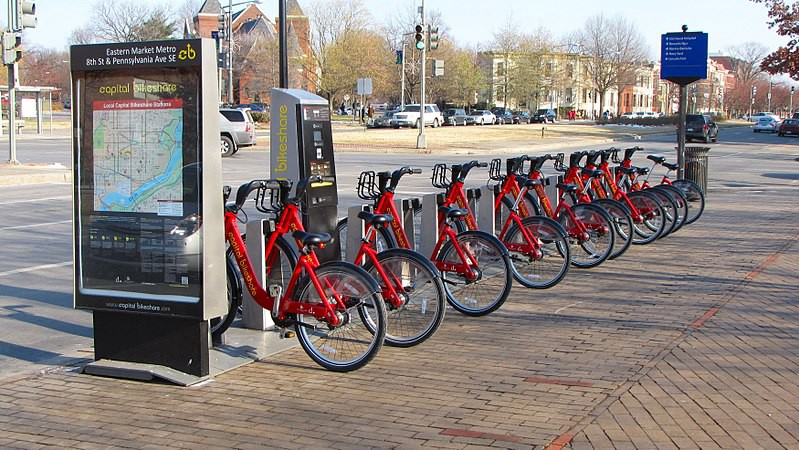



# <b><u> Seoul Bike Sharing Demand Prediction </u></b>

In [99]:
pip install shap


     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491637 sha256=8cc8fdec2354d358f39014aed887c58846eae2a647855153819dd6269cfaeab1
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [100]:
import shap
from plotnine import*
import datetime as dt
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
from plotly.offline import init_notebook_mode
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## **Reading and importing Data**

In [2]:
bike_df = pd.read_csv('https://raw.githubusercontent.com/gyana-ranjan-dash/Seoul_Bike_Sharing_Demand_Prediction/main/SeoulBikeData.csv',encoding= 'unicode_escape',date_parser="Date")

In [3]:

bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### **Understanding the Data**

In [4]:
# checking the shape of the dataset
bike_df.shape

(8760, 14)

Our dataset contains ``8760`` rows and ``14`` columns



In [5]:
# checking for the data types and null values in the dataset
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

 **Initial Observations**


*   ``date`` columns must be in data format not in object format



In [6]:
bike_df.describe(include='all', percentiles=[.25, .50, .75, .95,.99])

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760
unique,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2
top,19/11/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,Yes
freq,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,8465
mean,NaN,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,NaN
std,NaN,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,NaN,NaN,NaN
min,NaN,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,NaN
75%,NaN,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,NaN


**Initial observation**


*   In the ``Rented Bike Count`` coloumn there seems to have few outliers
*   In the ``Snowfall`` column there is a huge difference between max and 99 percentile, looks  like an outlier



In [7]:
#cheking for null values 
bike_df.isnull().mean()

Date                         0.0
Rented Bike Count            0.0
Hour                         0.0
Temperature(°C)              0.0
Humidity(%)                  0.0
Wind speed (m/s)             0.0
Visibility (10m)             0.0
Dew point temperature(°C)    0.0
Solar Radiation (MJ/m2)      0.0
Rainfall(mm)                 0.0
Snowfall (cm)                0.0
Seasons                      0.0
Holiday                      0.0
Functioning Day              0.0
dtype: float64

**Initial observations**


  


*    Looks like there are no ``NULL`` values in the dataset



### **Cleaning and modifying the data**

In [8]:
# converting date column to datatime format
bike_df['Date']=pd.to_datetime(bike_df['Date'])

In [9]:
# Extracting year, day , month and weekdays from the date column
bike_df['Year'] = pd.DatetimeIndex(bike_df['Date']).year
bike_df['Day'] = pd.DatetimeIndex(bike_df['Date']).day
bike_df['Month']= pd.DatetimeIndex(bike_df['Date']).month
bike_df['weekday']=pd.DatetimeIndex(bike_df['Date']).weekday

In [10]:
bike_df['weekday'].unique()

array([3, 6, 2, 4, 0, 5, 1])



--- As the weekdays are in the range ``[0-6]`` we need to change this from ``[1-7]``



In [11]:
bike_df['weekday'] = bike_df['weekday'] +1
bike_df['weekday'].unique()

array([4, 7, 3, 5, 1, 6, 2])

In [23]:
(bike_df['Solar Radiation (MJ/m2)'].value_counts()/ len(bike_df['Solar Radiation (MJ/m2)']))*100

0.00    49.086758
0.01     1.461187
0.02     0.936073
0.03     0.787671
0.06     0.696347
          ...    
3.44     0.011416
3.35     0.011416
3.38     0.011416
2.97     0.011416
2.69     0.011416
Name: Solar Radiation (MJ/m2), Length: 345, dtype: float64

Nearly ``50%`` of data in ``Solar Radiation (MJ/m2)`` coulumn is ``0``, we can say this column does not affect the result and we can drop this

In [24]:
bike_df.drop('Solar Radiation (MJ/m2)', axis = 1, inplace = True)

### **Exploratory data analysis**

In [25]:
bike_df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Day,Month,weekday
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,4


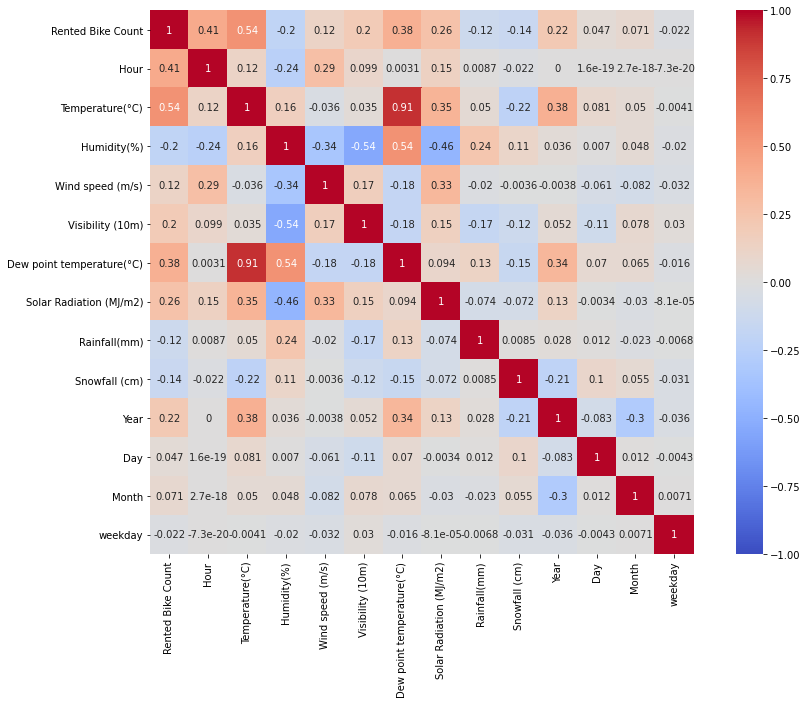

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(bike_df.corr("pearson"),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True, 
            square=True);

**Insights**


*   There is a high correlation between ``Temperature`` and ``Dew point temperature`` No point of keeping both of them in the dataset. 



In [26]:
# dropping Dew point temperature column from the dataset
bike_df.drop('Dew point temperature(°C)', axis = 1, inplace = True)

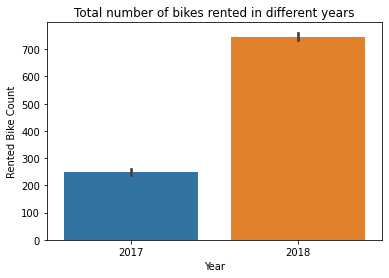

In [46]:
sns.barplot(x = 'Year', y = 'Rented Bike Count', data = bike_df)
plt.title("Total number of bikes rented in different years")
plt.show()

**Insights**


*   We can clearly see that the total number of bikes rented in the year ``2018`` in much higher than the total number of bikes rented in the year ``2017``



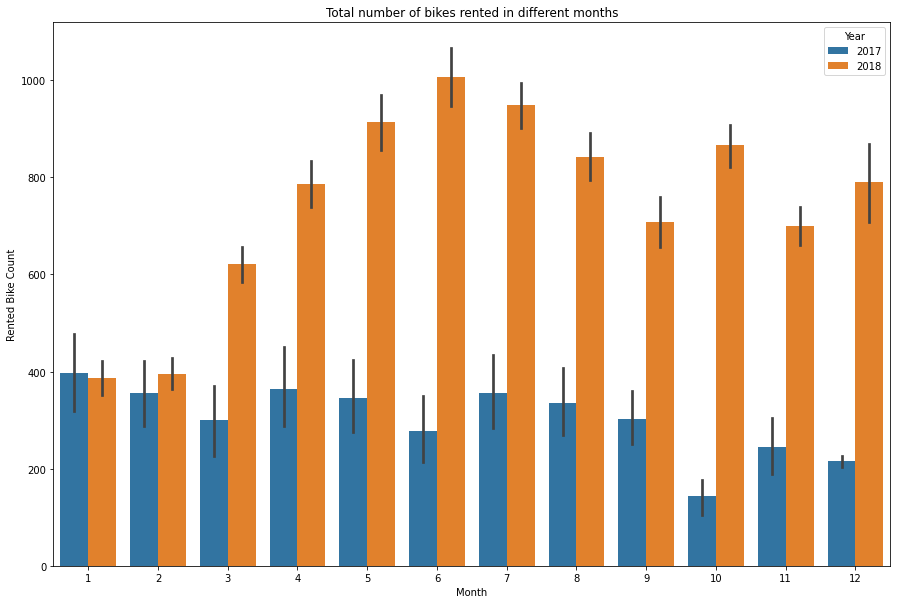

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(x = 'Month', y = 'Rented Bike Count', data = bike_df, hue = 'Year')
plt.title("Total number of bikes rented in different months")
plt.show()

**Insights**


1.   From the above plot we can say that in the month of ``jan`` and ``feb`` there is not much of a difference in the sales, but later the sales increase drastically in the year ``2018``


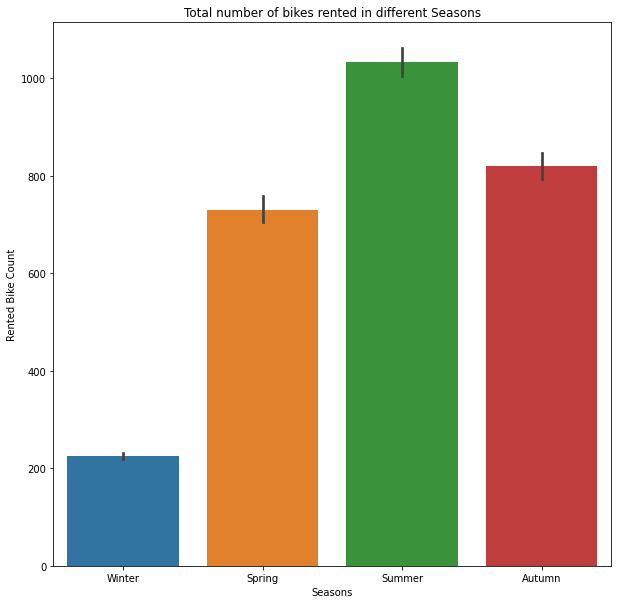

In [63]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'Seasons', y = 'Rented Bike Count', data = bike_df)
plt.title("Total number of bikes rented in different Seasons")
plt.show()

In [86]:
bike_df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Rainfall(mm)', 'Snowfall (cm)',
       'Seasons', 'Holiday', 'Functioning Day', 'Year', 'Day', 'Month',
       'weekday'],
      dtype='object')

In [135]:

for i in bike_df.describe().columns:
  if i not in ['Rented Bike Count','Year','Day','Month','weekday','Hour']:
    display(px.scatter(bike_df,i,'Rented Bike Count',trendline="ols",trendline_color_override='yellow',opacity=0.6,title=f"{i} and Rented Bike Count"),width=500,length=500)

**Insights**

From above plots we can say



*   ``Temperature`` affects the the number of rented bike directly, People prefer to rent bikes in a hotter days.
*   ``humidity`` Doest not affect the number of rented bikes much
*   If the  ``windspeed`` is high people less likely to rent a bike
*   When the ``visibility`` is low  the number of rented bikes is also low
*   When there is a heavy ``snowfall`` people less likely to rent a bike









Text(0.5, 1.0, 'Holiday')

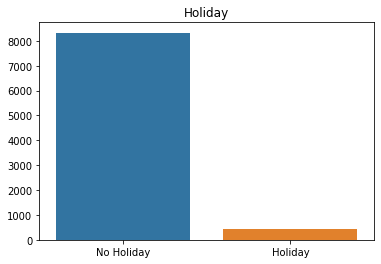

In [124]:
sns.barplot(df['Holiday'].unique(),list(pd.DataFrame(bike_df['Holiday'].value_counts()).iloc[:,0]))
plt.title('Holiday')



--- Most number of bikes are rented when there is no holiday.

